Due to zero padding our signal is convolved with a sinc function. This notebook aims to find the params of that sinc funtion so we can deconvolve/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd

from forward.fourier.kernel_creator import *
import scipy.ndimage
from scipy.ndimage import rotate

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2
device = 'cuda:2'

desired_range = [735,865]


def ConvolveKernel(original, kernel):
    
    nx = kernel.shape[0]
    
    # kernel = np.fft.fftshift(kernel)
    kernelpad = np.pad(kernel,(nx//2,nx//2))
    originalpad = np.pad(original,(nx//2,nx//2))
    
    kernel_fft = np.fft.fft(kernelpad)
    original_fft = np.fft.fft(originalpad)#,axis=1)

    recon = np.abs(np.fft.ifftshift(np.fft.ifft(original_fft * kernel_fft)))

    recon = recon[nx//2:-(nx//2)]

    return recon

def WienerDeconvolution(final, kernel, lamb = 0.001):
    
    nx = kernel.shape[0]
    
    # kernel = np.fft.fftshift(kernel)
    kernelpad = np.pad(kernel,(nx//2,nx//2))
    finalpad = np.pad(final,(nx//2,nx//2))
    
    kernel_fft = np.fft.fft(kernelpad)
    final_fft = np.fft.fft(finalpad)

    original_fft=(np.conj(kernel_fft)*final_fft)/ (np.square(np.abs(kernel_fft))+ lamb)


    original = np.abs(np.fft.ifftshift(np.fft.ifft(original_fft)))

    original = original[nx//2:-(nx//2)]

    return original


4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40


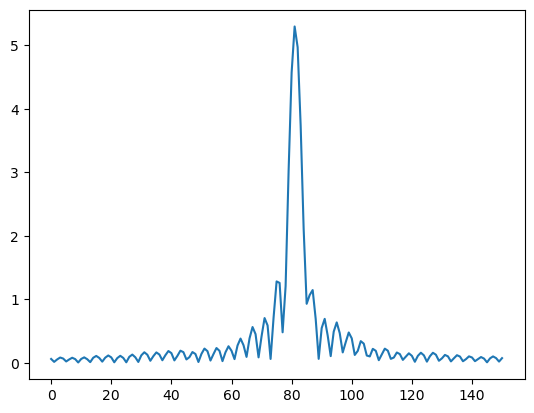

In [3]:
# dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230925_1grating_pinhole_data_exptime_3500_us/'
# anadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230925_1grating_pinhole_analysis_exptime_3500_us/'
# positions = np.load(dir + 'positions.npy')

# cube = np.load(anadir+'signalfft_1D_mean_padded_thresholded_new.npy')
# freqs = np.load(anadir+'freqs_1D_mean_padded_thresholded_new.npy')#*1e9



dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_pinhole_data_exptime_8000_us/'
positions = np.load(dir + 'positions.npy')

# anadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS//'

cube,wavls,freqs = hlp.load_cube('20230906_1grating_pinhole_analysis_exptime_8000_us', 'padded_center_fixed_thresholded_new', onefile=False )

max_loc = np.where(cube[:,:700] == np.max(cube[:,:700]))
# cube =  np.load(anadir+'signalfft_1D_mean_padded_thresholded_new.npy')
# wavls = np.load(anadir+'wavls_1D_mean_padded_thresholded_new.npy')#*1e9
# freqs = np.load(anadir+'freqs_1D_mean_padded_thresholded_new.npy')#*1e9

plt.plot(cube[max_loc[0][0],max_loc[1][0],:])



In [4]:
dx = np.mean((positions[1:] - positions[:-1])) * 1e-3

In [20]:
dx

3.999799732977303e-08

In [5]:
resolution = 1000
E_0 = np.eye((resolution)) #position x wl
wls = np.linspace(750,850,resolution)

E_0[:,((wls<750) | (wls > 850))] = 0

Text(0, 0.5, 'position')

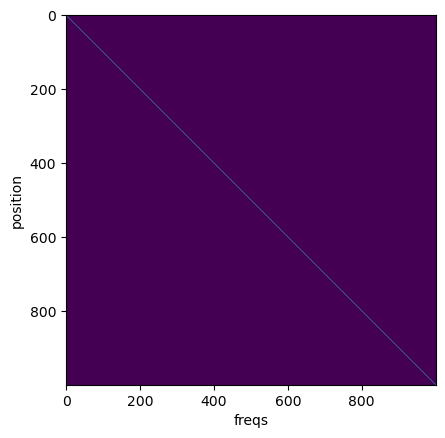

In [6]:
plt.imshow(E_0)
plt.xlabel('freqs')
plt.ylabel('position')

In [7]:
I = np.zeros((len(positions), len(E_0)))

modfactors = np.zeros((len(positions), resolution))

pos = - dx * (len(positions)/2)



for i in range(len(positions)):
    modfactors[i] = np.cos(2*np.pi * 2*pos / (wls*1e-9))

    temp = E_0 * 0.5 * (1 + modfactors[i])
    
    I[i] = np.sum(temp**2, axis=-1)
    pos+=dx


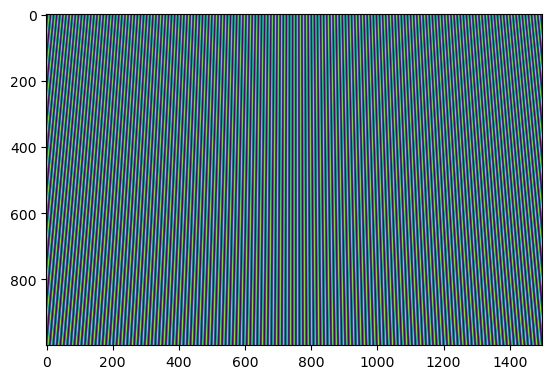

In [8]:
plt.imshow(I.T)

Text(0, 0.5, 'position')

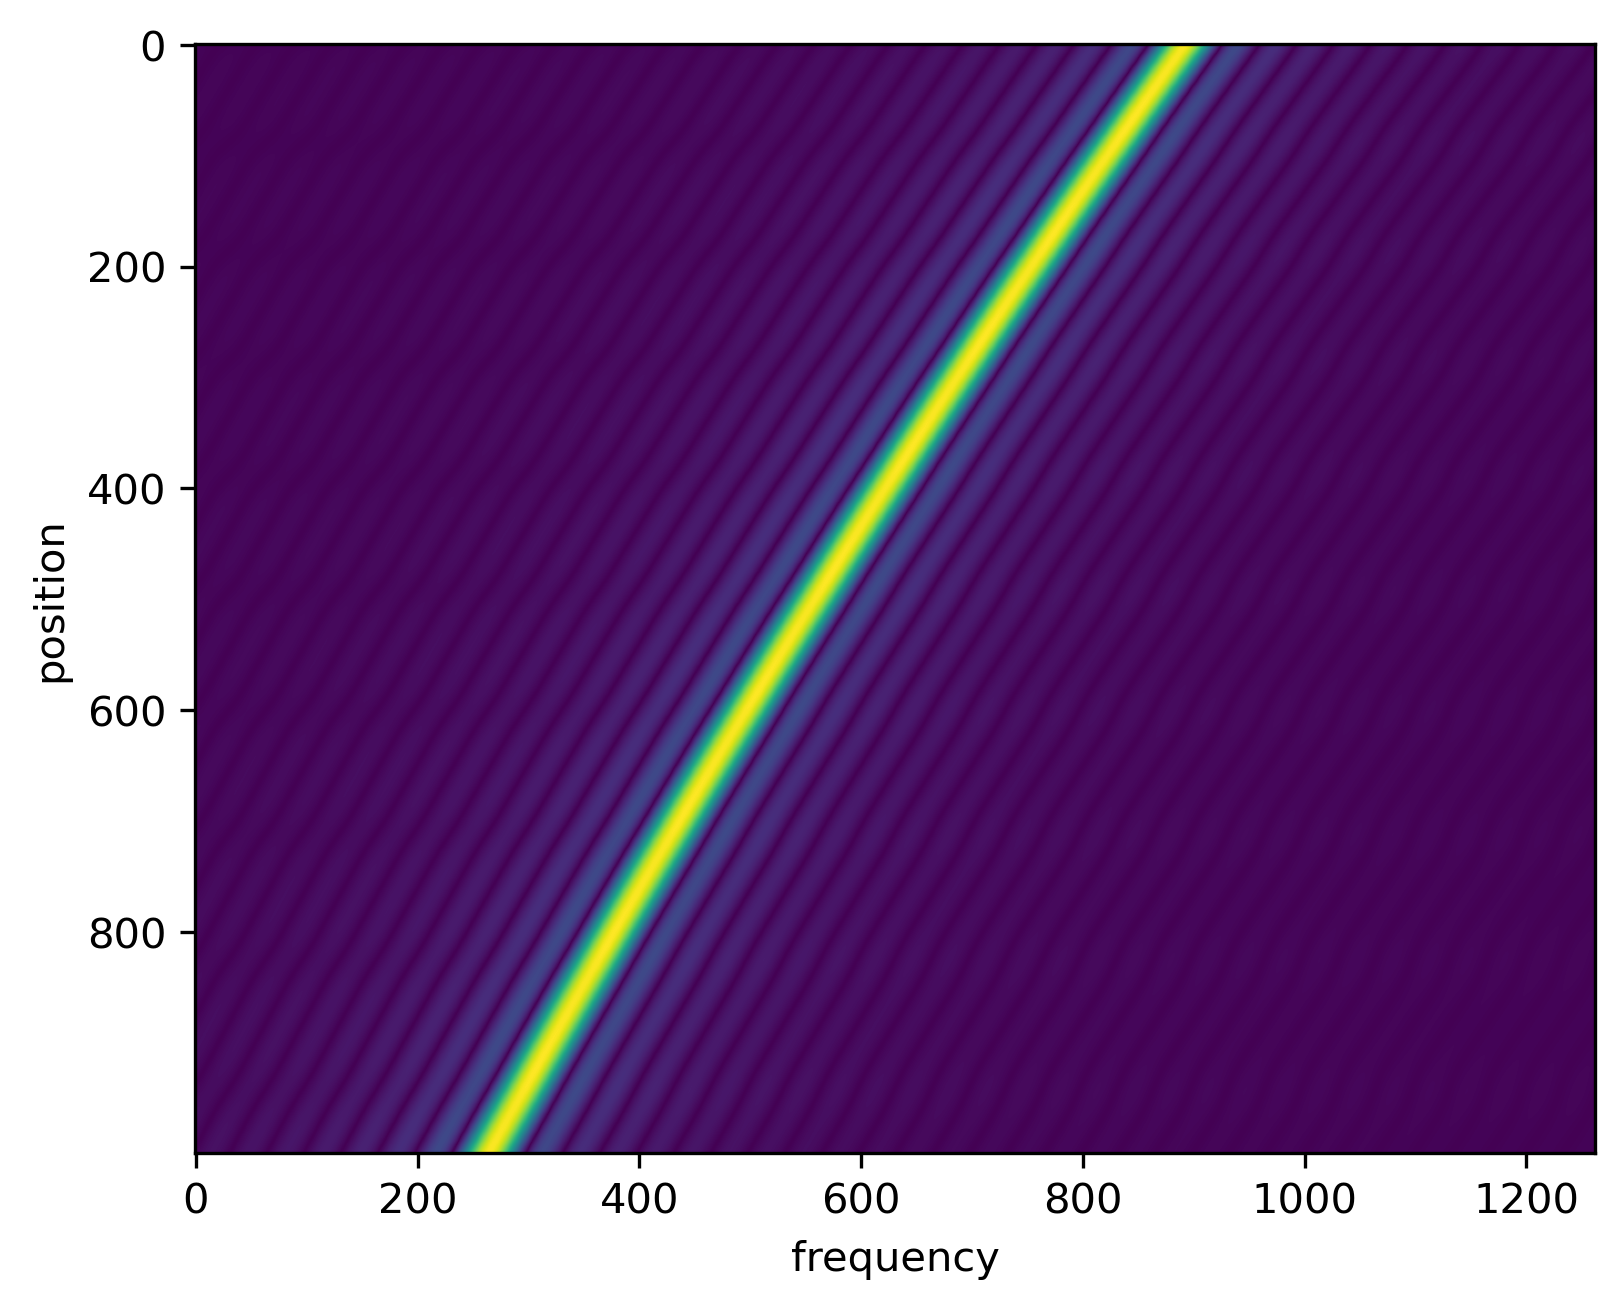

In [9]:
zeropad = 50000

I_pad = np.zeros((zeropad, resolution))
I_pad[:len(positions)] = I

If = np.abs(np.fft.fft(I_pad, axis=0)).T # pos x wl
f = np.fft.fftfreq(len(I_pad), d=2*dx /3e8)

# wl_ = 3e8 / f



If = If[:,((f>freqs[0]) & (f < freqs[-1]))]

f = f[((f>freqs[0]) & (f < freqs[-1]))]

# box = If[:,50] != 0

# If = If[box]


plt.figure(dpi=300)
plt.imshow(If)
plt.xlabel('frequency')
plt.ylabel('position')

Text(0.5, 0, 'frequency')

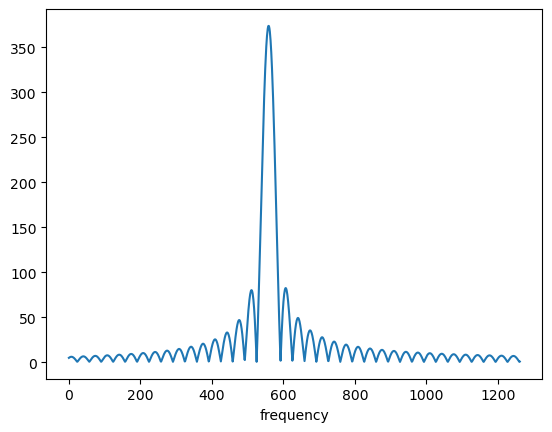

In [10]:
exno = 500

egdata = If[exno,:]

plt.plot(egdata)
plt.xlabel('frequency')

### Find the kernel by fitting a sinc function. 

[ 3.74021110e+02  1.88653443e+01 -1.14221075e-01] [[2.01119477e-02 2.67219740e-05 2.70061895e-09]
 [2.67219740e-05 2.70534685e-06 2.82485235e-10]
 [2.70061895e-09 2.82485235e-10 1.22557441e-10]]


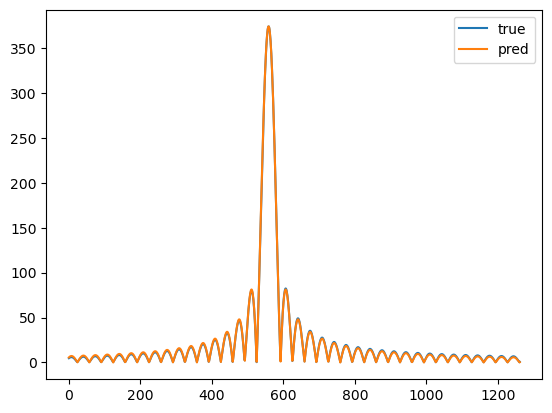

In [11]:
from scipy.optimize import curve_fit



def sincSquare_mod(x,*p):
    A, freq, x0 = p
    return A * np.abs(np.sinc((x-x0) * freq))

p0 = [350., 20, -0.1]

fitdata = egdata
x = np.linspace(-1,1,len(fitdata))
x_big = np.linspace(-2,2,2 * len(fitdata))
dx = x[1]-x[0]
# x_big = np.concatenate([np.arange(-3,-1,dx), x, np.flip(np.arange(3,1,-dx)),])


p1, var_matrix = curve_fit(sincSquare_mod, x, fitdata, p0, )
print(p1, var_matrix)

plt.plot(fitdata)
plt.plot(sincSquare_mod(x,*p1))
plt.legend(('true','pred'))


p1[-1] = 0
# kernel_fitted = sincSquare_mod(x_big,*p1)
kernel_fitted = sincSquare_mod(x,*p1)
kernel_fitted = kernel_fitted / np.sum(kernel_fitted
)



Text(0.5, 1.0, 'Deconvolved')

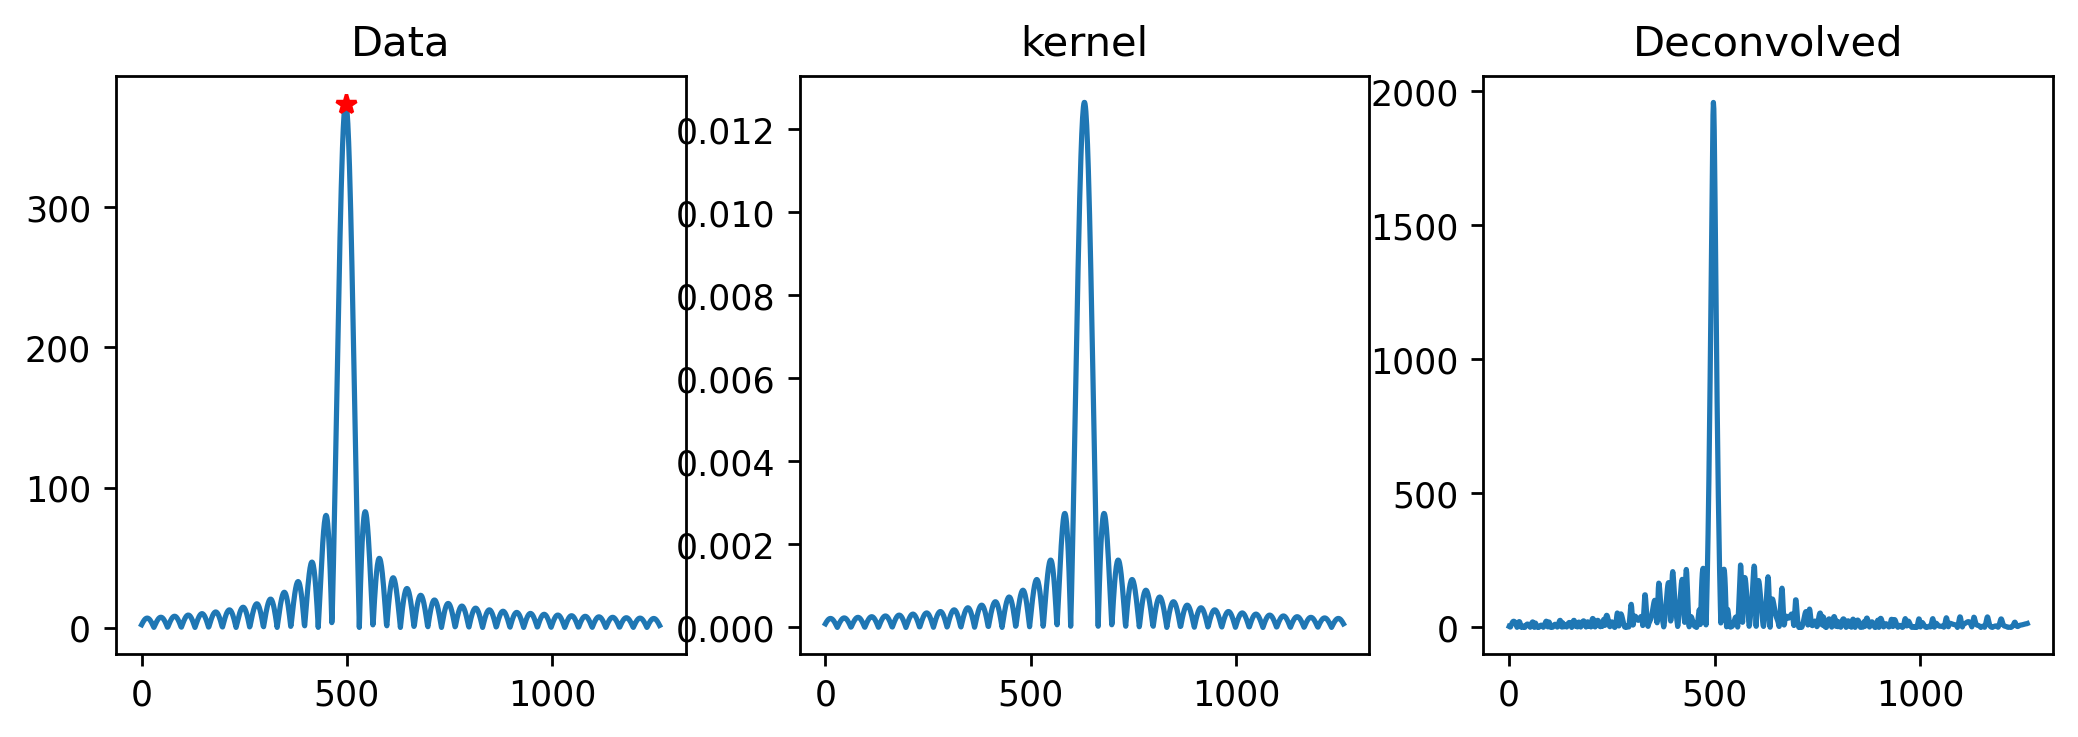

In [12]:
exno = 600

test = If[exno]

# test = np.pad(test, (len(test)//2,len(test)//2))

recon = WienerDeconvolution(test,kernel_fitted)

peak_pred = np.argmax(recon)

fig,ax = plt.subplots(1,3,dpi=250, figsize = (10,3))
ax[0].plot(test); ax[0].set_title('Data')
ax[0].plot([peak_pred],[p1[0]],'r*' )
ax[1].plot(kernel_fitted); ax[1].set_title('kernel')
ax[2].plot(recon); ax[2].set_title('Deconvolved')



### Now can we take the sinc modulation away from the real data?

In [13]:
#first need to interpolate the kernel down to the same resolution as the data

kernel_fitted_interp = np.interp(freqs, f, kernel_fitted)


In [14]:
p0

[350.0, 20, -0.1]

Text(0.5, 1.0, 'Deconvolved')

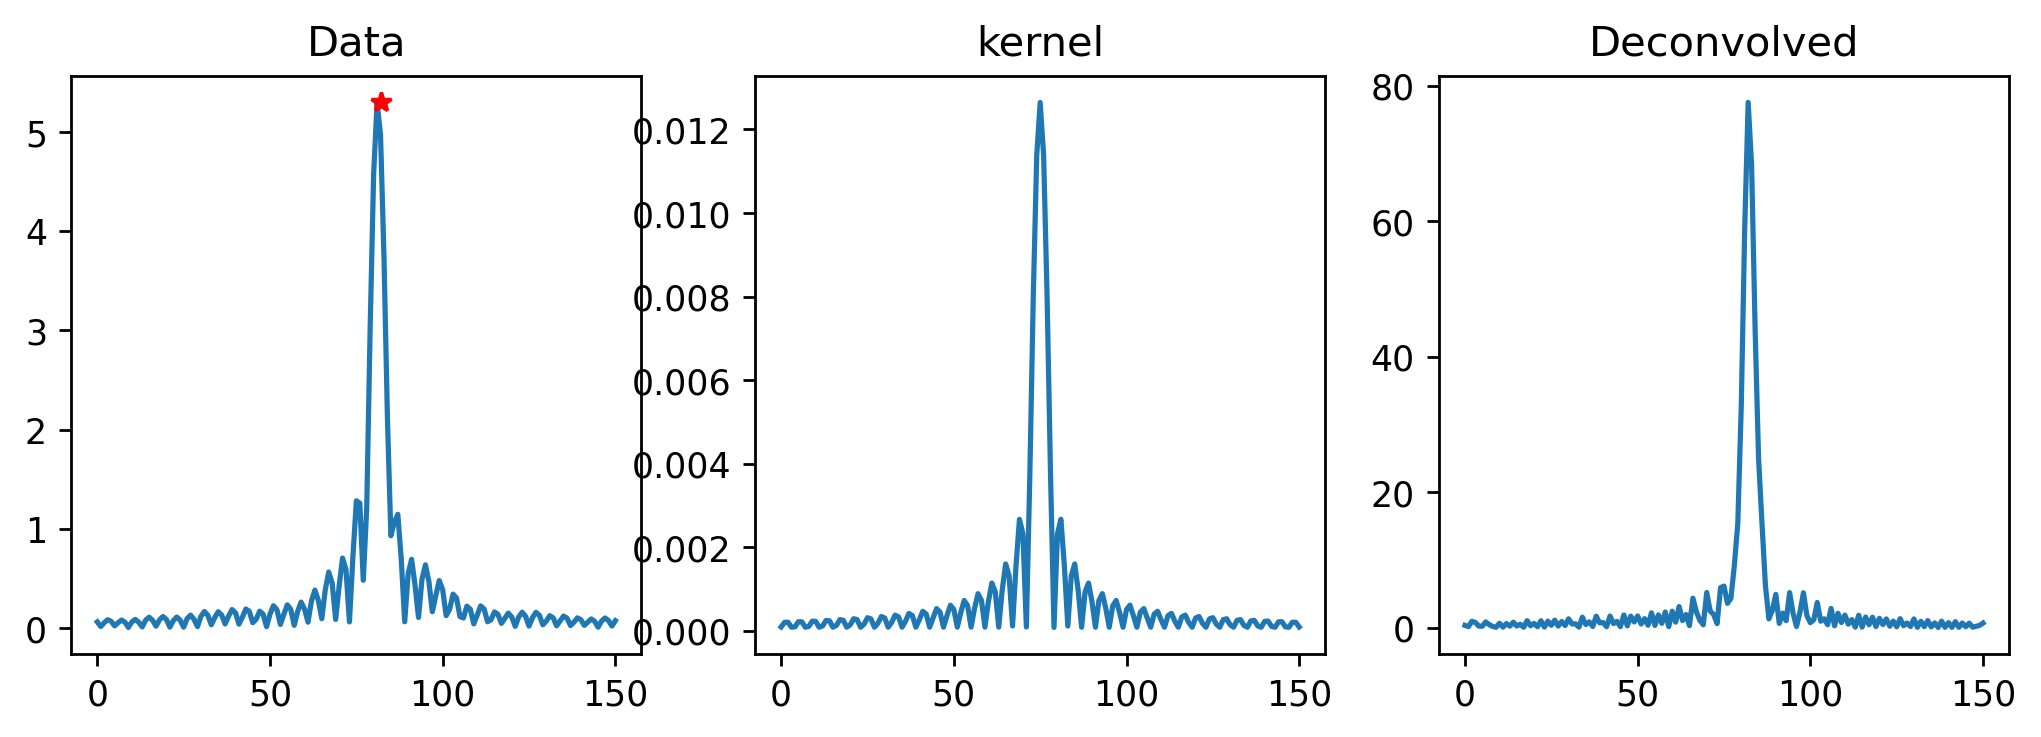

In [17]:
exno = 600

test = cube[max_loc[0][0],max_loc[1][0],:]

recon = WienerDeconvolution(test,kernel_fitted_interp)

peak_pred = np.argmax(recon)

fig,ax = plt.subplots(1,3,dpi=250, figsize = (10,3))
ax[0].plot(test); ax[0].set_title('Data')
ax[0].plot([peak_pred],test.max(),'r*' )
ax[1].plot(kernel_fitted_interp); ax[1].set_title('kernel')
ax[2].plot(recon); ax[2].set_title('Deconvolved')


In [227]:
np.save('../sincdeconvolutionkernel.npy', kernel_fitted_interp)

### This next section looks at making the spectra right.

In [261]:
desired_range = [750,850]

In [262]:
# _, spectras = hlp.create_bs_data(desired_channels=50, fts_dir = '20230925_1grating_pinhole_data_exptime_3500_us', desired_range=desired_range, device=device )
spectras = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230925_1grating_pinhole_data_exptime_3500_us/spectra.npy')
initial_bins = np.linspace(634.69, 1124.5, spectras.shape[0])

spectras = spectras[((initial_bins>desired_range[0]) & (initial_bins < desired_range[1]))]
freqs = torch.tensor(initial_bins[((initial_bins>desired_range[0]) & (initial_bins < desired_range[1]))])

df = freqs[1] - freqs[0]

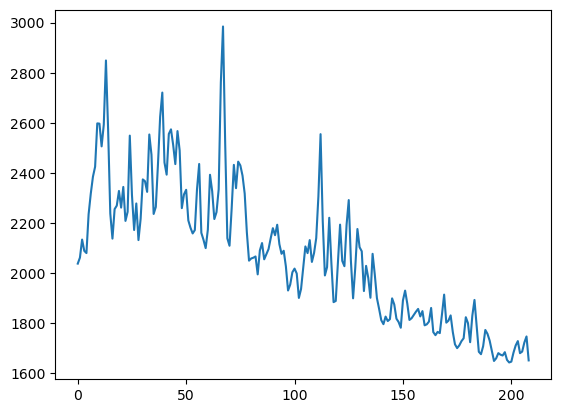

In [303]:
mean_spectra = np.mean(spectras,axis=1)
plt.plot(mean_spectra)
# from scipy.ndimage import gaussian_filter1d

# mean_spectras_smooth = gaussian_filter1d(mean_spectra, 10)

# normed_spectra = spectras / mean_spectras_smooth[:,None]
normed_spectra = spectras / mean_spectra[:,None]
normed_spectra = torch.tensor(normed_spectra)

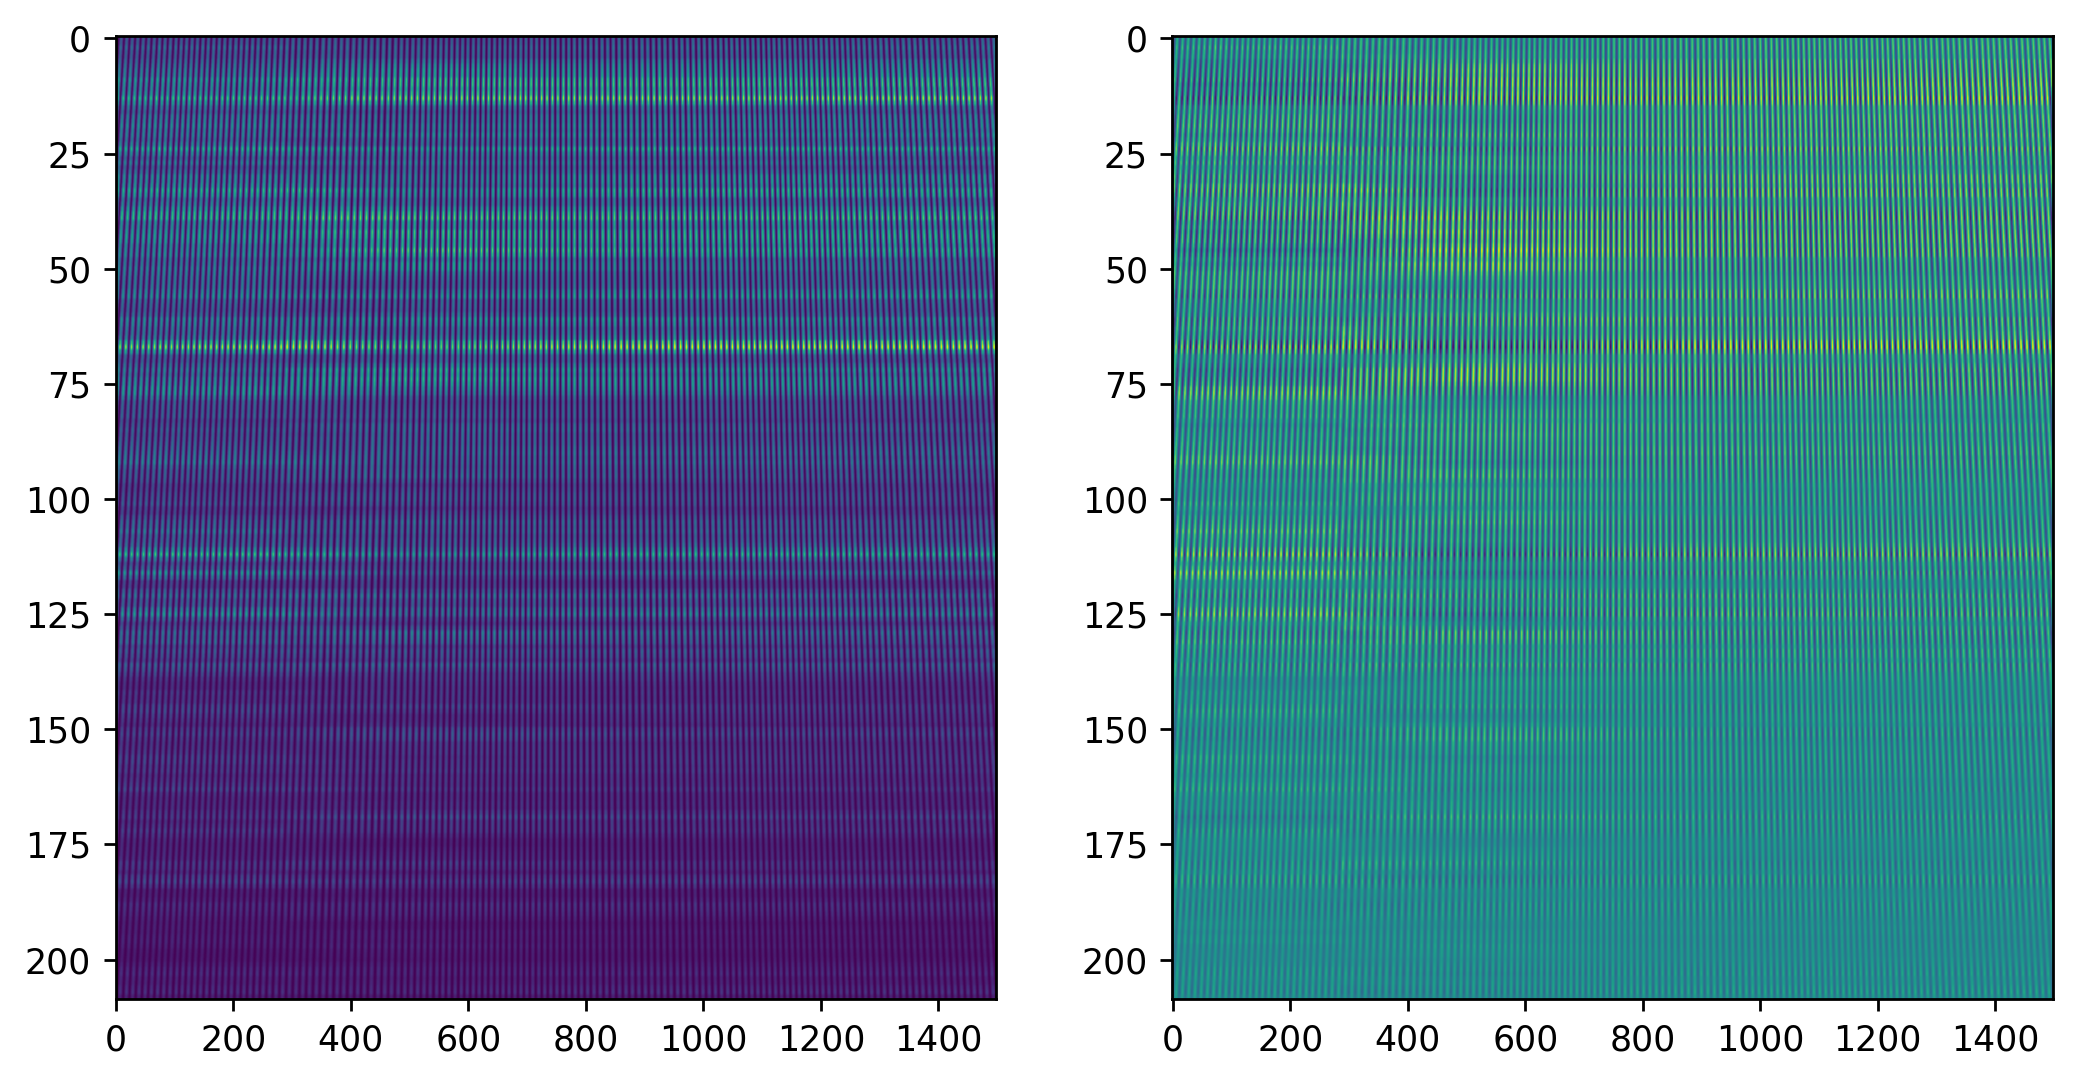

In [306]:
fig,ax = plt.subplots(1,2,figsize=(10,5),dpi=250)
ax[0].imshow(spectras, aspect='auto')#
ax[1].imshow(normed_spectra,aspect='auto')

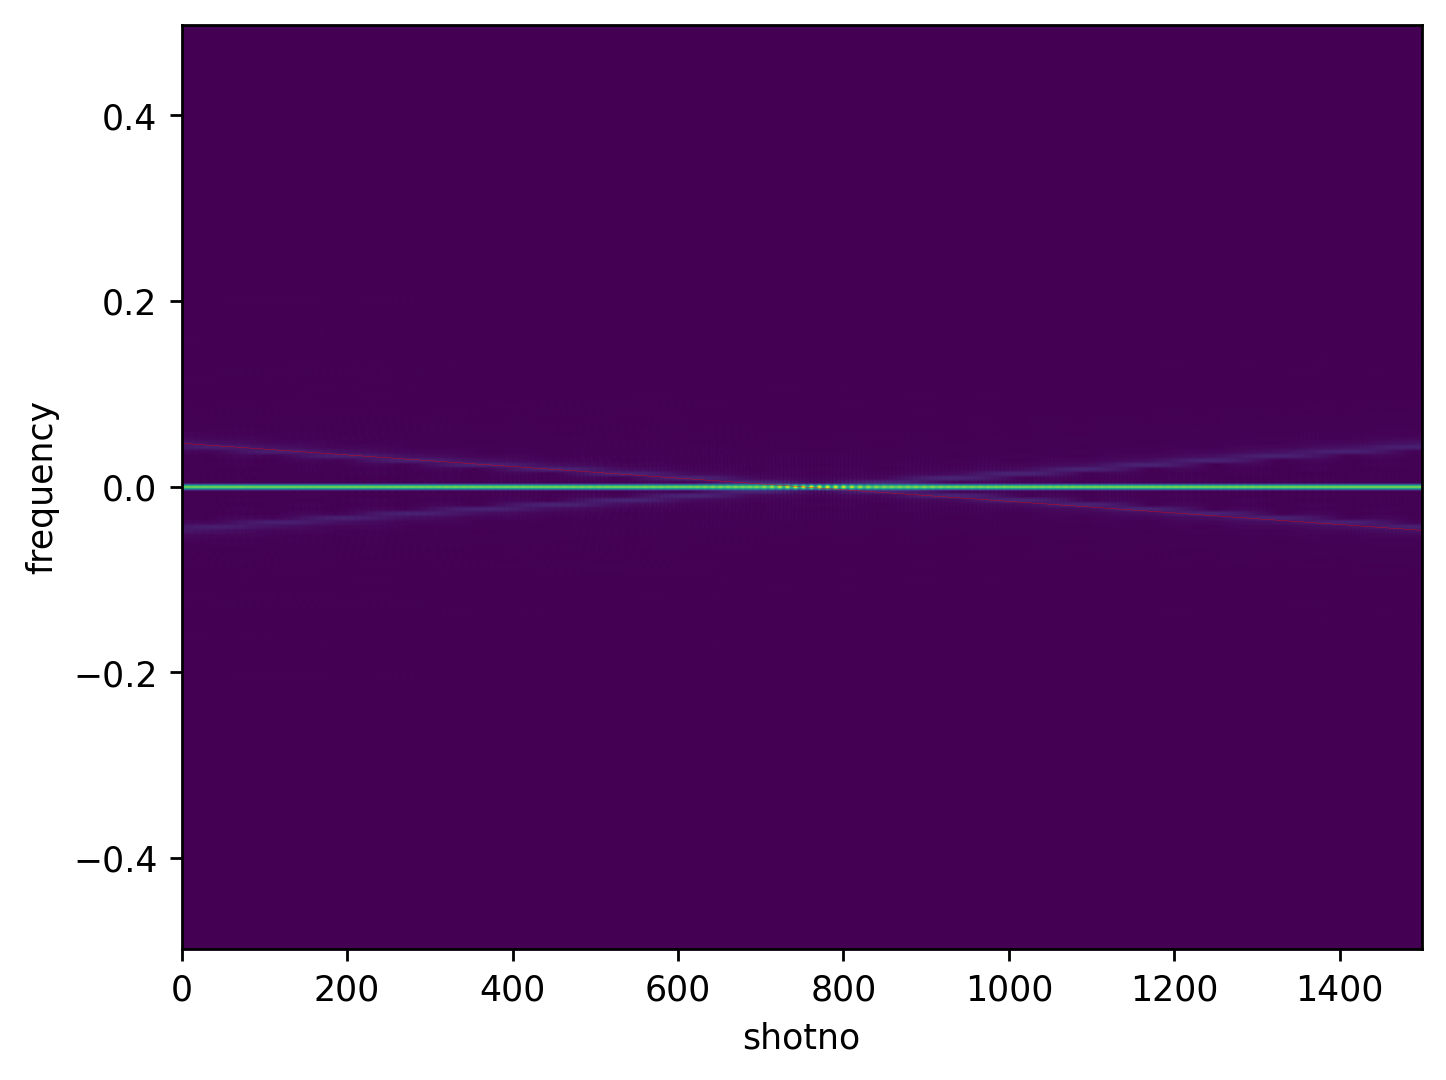

In [309]:
fft_spectra = np.abs(np.fft.fftshift(np.fft.fft(normed_spectra, axis=0),axes=0))

length = fft_spectra.shape[1]

bla = np.fft.fftshift(np.fft.fftfreq(len(normed_spectra), d=1))

plt.figure(dpi=250)
plt.imshow(fft_spectra, extent = [0,length,bla[0],bla[-1]],aspect='auto'); plt.xlabel('shotno'); plt.ylabel('frequency')

threshold = 0.2
from scipy import ndimage

uber0 = fft_spectra[bla>0]
uber0[uber0<uber0.max()*threshold] = 0
ele = ndimage.center_of_mass(uber0[:,0])[0]
init = bla[bla>0][np.floor(ele).astype(int)] * (1-ele%1) + bla[bla>0][np.ceil(ele).astype(int)] * (ele%1)

unter0 = fft_spectra[bla<0]
unter0[unter0<unter0.max()*threshold] = 0
ele = ndimage.center_of_mass(unter0[:,0])[0]
final = bla[bla<0][np.floor(ele).astype(int)] * (1-ele%1) + bla[bla<0][np.ceil(ele).astype(int)] * (ele%1)

plt.plot([0,length],[init,final], 'r', linewidth=0.1)

frequency = np.arange(length) / length * (final - init) + init

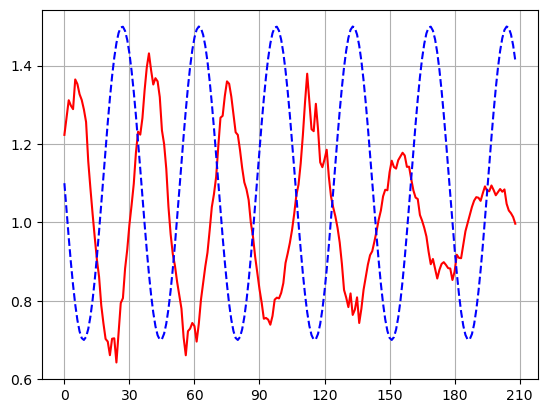

In [310]:
shotno = 1200


plt.plot(normed_spectra[:,shotno],'r')
plt.plot(1.1 + .4 * np.sin(2*np.pi*frequency[shotno]*np.arange(len(normed_spectra))),'b--')
plt.xticks(np.arange(0,220,30))
plt.grid()


In [311]:
def func(x, a, b, c, d):
    return a + b * np.sin(2*np.pi* c * x + d)
xpos = np.arange(len(normed_spectra))

pred_spectras = np.zeros_like(normed_spectra)


for i in range(len(normed_spectra[0])):
    p0 = [1., 0.5, frequency[i], 0.]
    y = normed_spectra[:,i]
    try:
        p1, var_matrix = curve_fit(func, xpos, y, p0)
        # p_ult = np.array([1, p1[1], p1[2], p1[3]])
        pred_spectras[:,i] = func(xpos, *p1)
    except:
        pred_spectras[:,i] = pred_spectras[:,i-1]

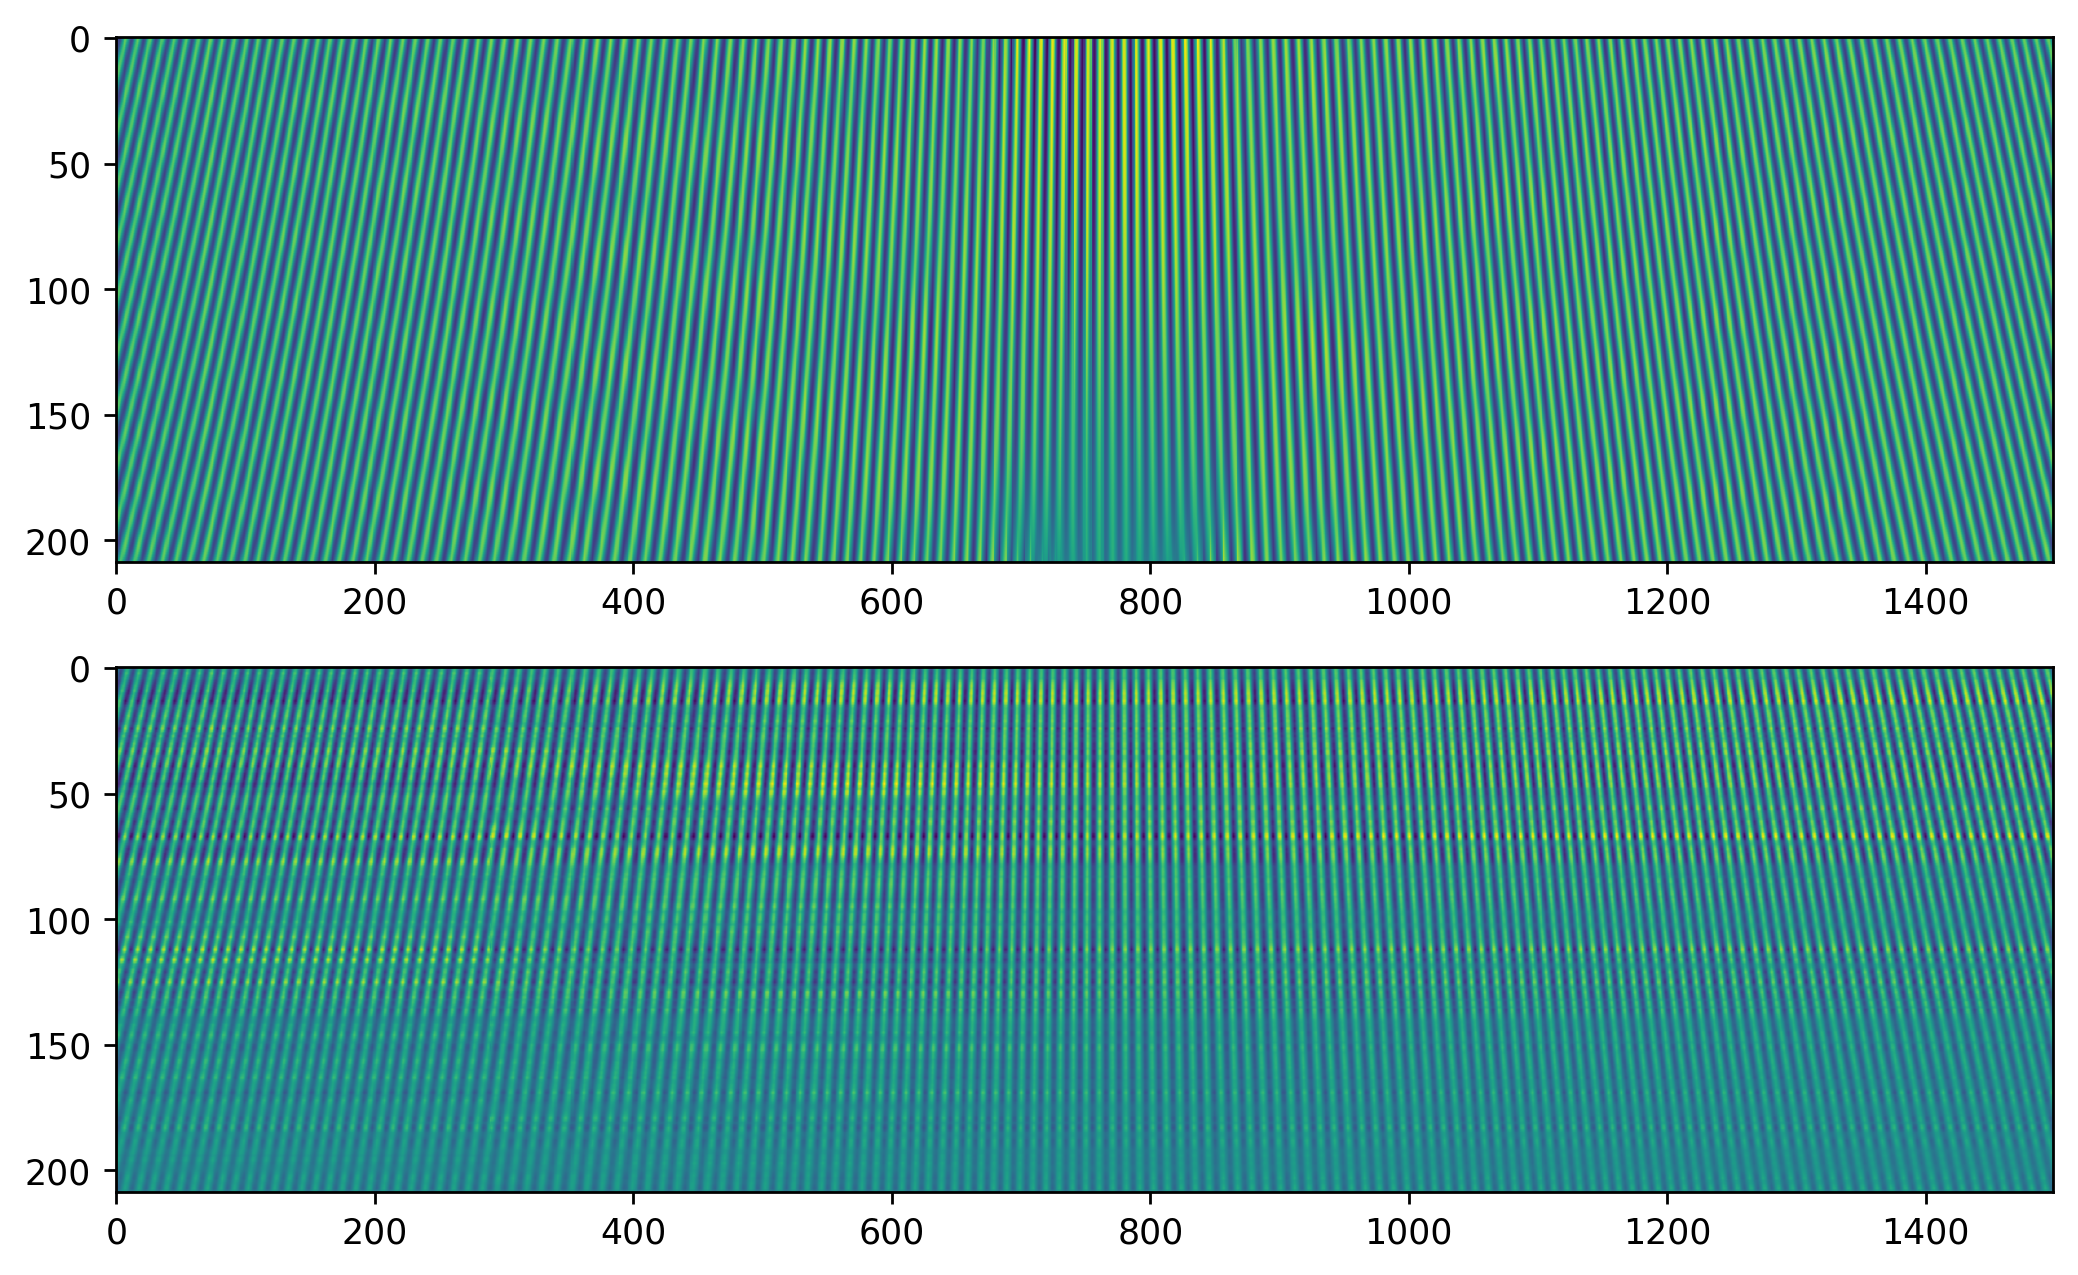

In [312]:
fig,ax = plt.subplots(2,1, figsize=(10,6), dpi=250)
ax[0].imshow(pred_spectras[:,:], aspect='auto')
ax[1].imshow(normed_spectra[:,:],aspect='auto')

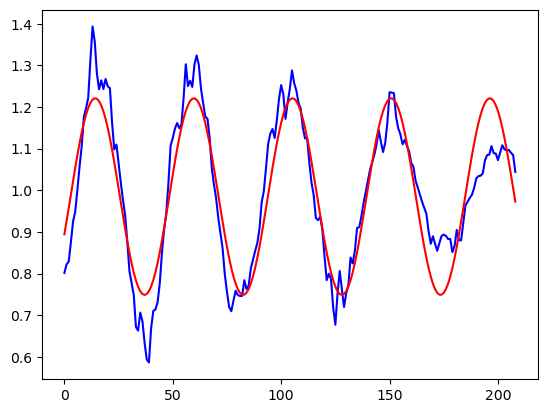

In [314]:


plt.plot(xpos, normed_spectra[:,400], 'b-', label='data')
plt.plot(xpos, pred_spectras[:,400], 'r-', label='fit')